# Lab 9: Recurrent Network Architectures

Preston Tighe, Arturo Laguna

In [20]:
import random
import warnings
import os
import sys
import copy
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
from scipy.misc import imread
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import keras
from keras import backend as K
from keras import utils
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, LSTM, Activation, GRU
from keras.models import Sequential, load_model, Input, Model
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

%matplotlib inline

## Preparation

We implemented a LSTM and GRU RNN to determine the positive or negative score from an IMDB review.

In [21]:
# from old keras
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batcwise average of precision.

    Computes the precision, a metric for multlabel classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batcwise average of recall.

    Computes the recall, a metric for multlabel classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
 
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batchwise average, not globally.

    This is useful for multilabel classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The Fbeta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a Fmeasure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

 
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [22]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

y_train_ohe = keras.utils.to_categorical(y_train)
y_test_ohe = keras.utils.to_categorical(y_test)

In [23]:
print(type(X_train),X_train.shape)
print(type(X_train[0]),X_train[0].shape)
print('Vocabulary size:', np.max(X_train))
print(y_train.shape)
NUM_CLASSES = len(np.unique(y_train))
print('Num classes:', NUM_CLASSES)

<class 'numpy.ndarray'> (25000, 500)
<class 'numpy.ndarray'> (500,)
Vocabulary size: 4999
(25000,)
Num classes: 2


In [24]:
EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, 
                EMBED_SIZE, 
                input_length=max_review_length)(input_holder)

for func in [LSTM, GRU]:
    
    x = func(50,dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy', fmeasure])
    print(rnn.summary())
    rnns.append(rnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
Total params: 270,302
Trainable params: 270,302
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________

### Metrics
We need to choose a method for scoring our classifier based on recall, precision, accuracy and $F_1$ score. There can only be 4 types of classification when classifying an image. They are true positive ($tp$), true negative ($tn$), false positive ($fp$) and false negative ($fn$).

We just need to maximize the true positives ($tp$) or the true negatives ($tn$). Accuracy does not take into account false positives ($fp$) so we need a metric that does this for us. We also want to minimize both false positives ($fp$) and false negatives ($fn$). The $F_1$ score does all of this for us with the formula: <br/> <br/> $$\qquad F_1 = \frac{2 (rp)}{(r + p)}$$ <br/> The $F_1$ score is the harmonic mean ($H$) using precision ($p$) and recall ($r$) <br/> <br/> $$p = \frac{tp}{tp+fp} \qquad r = \frac{tp}{tp+fn}$$ <br/> We use the harmonic mean ($H$) here because we are dealing with ratios when we are finding the probability. Therefore we are going to use F1 to evaluate our RNN models.


### Dividing Data Methods
We needed to choose a method for splitting our data set into even smaller sets that more closely resemble a real-life scenario. Reasoning being we don't get to train every sample of data that comes in before needing to predict what its outcome will be. We have a couple of tools to use for our training-test model selection: basic percent based train-test, K-folds, shuffle splits and stratified K-fold. We could reliably pick any of the model selection techniques and still get decent results. However, some of the techniques are significantly better than the others. We also want to actually use a cross-validation technique rather than a simple test-train split, as it helps us to try out every data sample in a training set. Accordingly, this leaves us with either stratified K-Fold splits or stratified shuffle splits. Randomly selecting X members of each class should not introduce any bias and using a shuffle split has the potential to be faster. Our final cross-validation technique will be stratified shuffle split using 2 splits to save training time.

## Modeling
### LSTM & GRU
We used 3 epochs and 2 splits to evaluate our models.

In [25]:
# cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2)
# for rnn, name in zip(rnns, ['lstm','gru']):
#     print('=======', name, '========')
#     base_weights = rnn.get_weights()
#     for index, (train_index, test_index) in enumerate(cv.split(X_train, y_train_ohe)):
#         print('    --------------- Split ' + str(index + 1) + '---------------')
#         rnn.set_weights(base_weights)
#         rnn.fit(X_train[train_index], y_train_ohe[train_index], epochs=3, batch_size=64, 
#                 validation_data=(X_test[test_index], y_test_ohe[test_index]))
#     rnn.save(name + '.h5')
#     print()

### Evaluation

In [26]:
lstm = load_model('lstm.h5', custom_objects={'fmeasure': fmeasure})
gru = load_model('gru.h5', custom_objects={'fmeasure': fmeasure})

In [27]:
def summarize_net(net, probas, model_type=''):
    yhat = np.argmax(probas, axis=1)
    plt.figure(figsize=(15, 5))
    acc = mt.accuracy_score(y_test, yhat)
    f1 = mt.f1_score(y_test, yhat, average="macro")
    cm = mt.confusion_matrix(y_test, yhat)
    cm = cm / np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title('Using ' + model_type + ' - F1: {:.4f}'.format(f1) + ' - Acc: {:.4f}'.format(acc))

In [28]:
def plot_roc(probas, xlim = None, ylim = None):
    plt.figure(figsize=(20,20))
    classes = np.unique(y_test)
    for j in classes:
        fpr, tpr, thresholds = mt.roc_curve(y_test, probas[:, j], pos_label=j)
        plt.plot(fpr,tpr,'--',lw=1,label='ROC for class %s (AUC=%0.4f)'
                     %(j, mt.auc(fpr, tpr)) )
    
    plt.legend(loc='best', prop={'size': 20})
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
        
    plt.title('ROC Curve')

In [29]:
probas_lstm = lstm.predict(X_test)

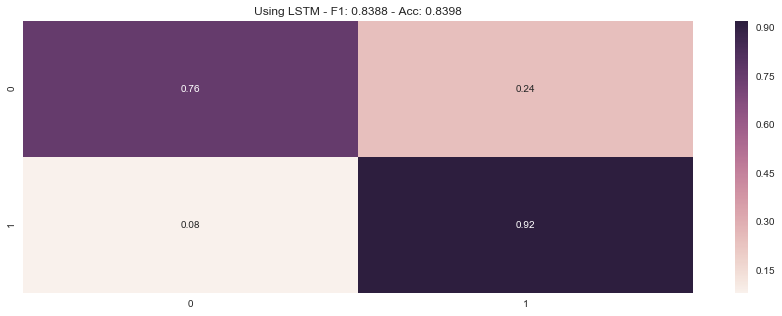

In [30]:
summarize_net(lstm, probas_lstm, model_type='LSTM')

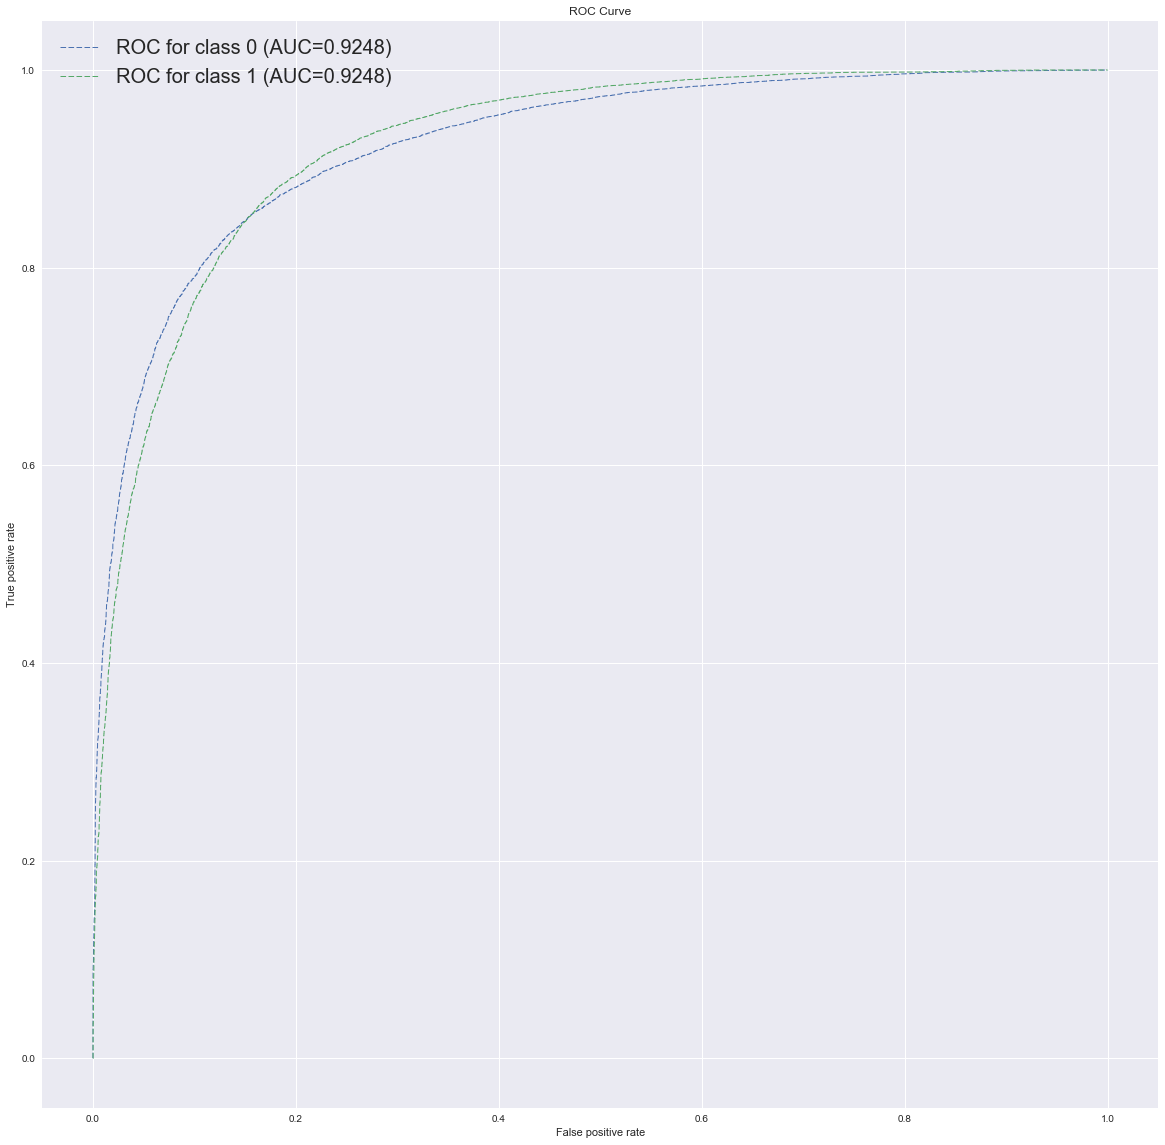

In [31]:
plot_roc(probas_lstm)

In [32]:
probas_gru = gru.predict(X_test)

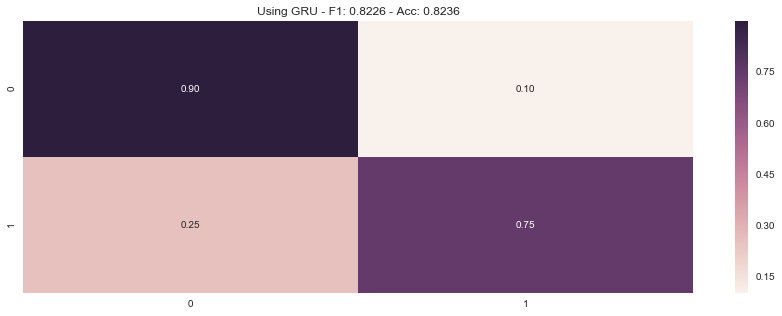

In [33]:
summarize_net(gru, probas_gru, model_type='GRU')

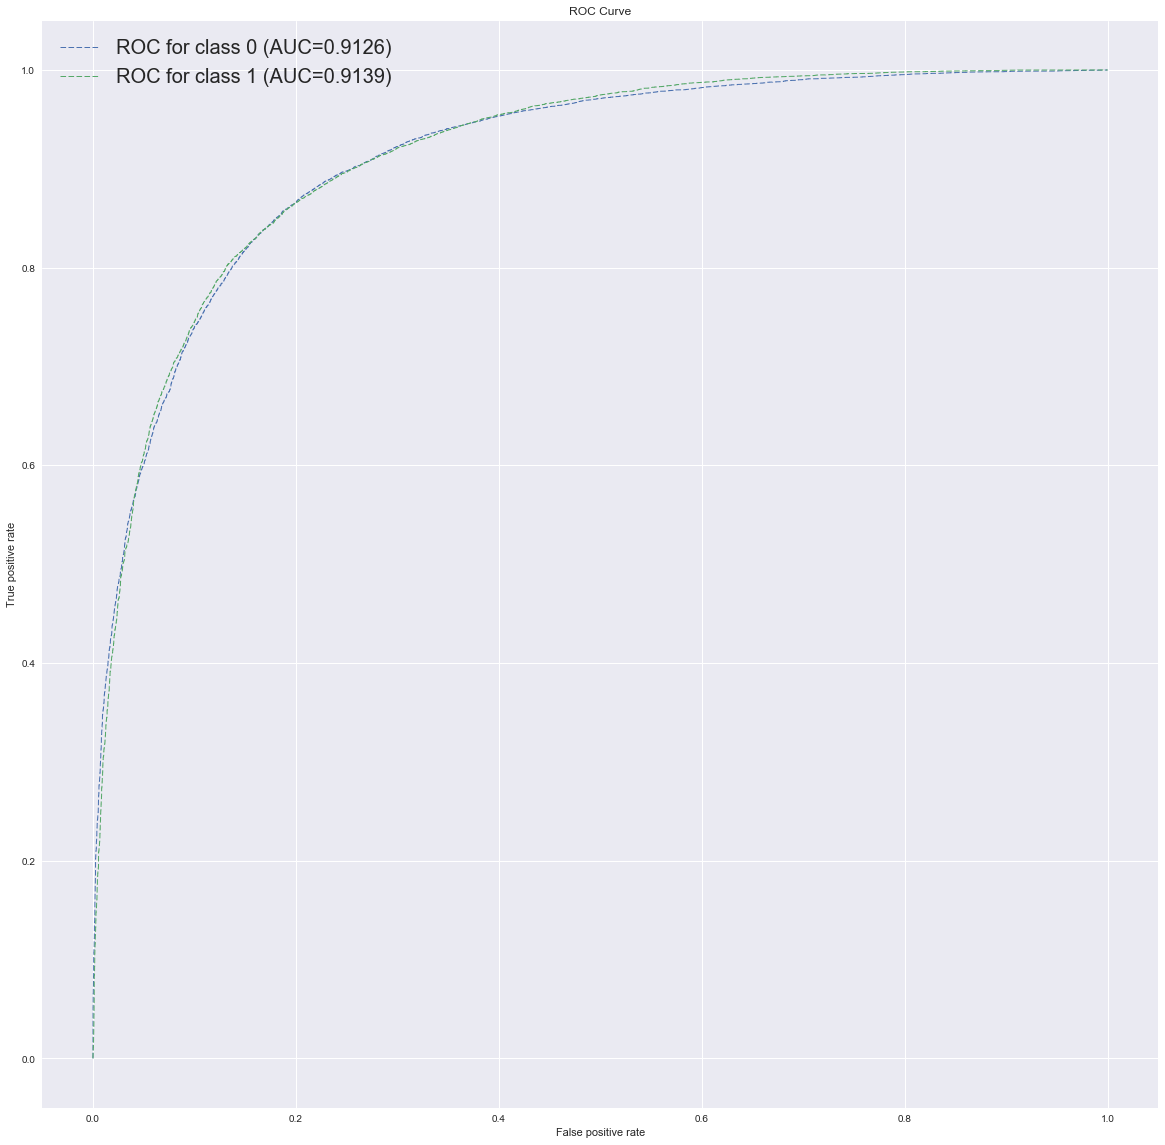

In [34]:
plot_roc(probas_gru)

The LSTM had a F1 of .833. The ROC looks ideal with an AUC of .9248.

The GRU was a little worse than the LSTM with a F1 score of .8226 and an AUC of .9126 which is barely lower than the LSTM. In other tests not shown above the GRU performed better. GRU's are better than LSTM's because they take less time to train and have just about the same F1/ROC/AUC metrics. If we had more time for training I see the GRU's being better in every aspect.

The LSTM was better at predicting positive reviews while the GRU was better at predicting negative reviews.

The ROC curves look great for both LSTM & GRUs.

## Text Generation

In [19]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 2):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


corpus length: 600901
total chars: 59
nb sequences: 200287
Vectorization...
Build model...

--------------------------------------------------
Iteration 1
Epoch 1/1
200287/200287 [==============================] - 317s - loss: 1.9763 - acc: 0.4246   

----- diversity: 0.2
----- Generating with seed: "d
almost owes itself.

261. vanity is on"
d
almost owes itself.

261. vanity is one deliefor of the compe_(al and decession of the there action of the cartions of the same and some allow the caster, and all the some a conscient of the religious of the sard of the some of the all the compense of the same and all the can for the some allogated of the same and there all the compense and alle all the there all the mand one in the compenses of the same and there all the conscience o

----- diversity: 0.5
----- Generating with seed: "d
almost owes itself.

261. vanity is on"
d
almost owes itself.

261. vanity is one one allothers of a pe_zain of something the for there for the respect of the for